# Machine Learning Engineer Nanodegree
# Capstone Project


## Analysis
------
### Getting started

Importing data
Used Meetup API
It's a list of users represented as Python dictionaries with the following information:
- City
- id
- Profile link
- Name
- topics
    - name
    - urlkey
    - id

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from collections import Counter
import cPickle as pickle
%matplotlib inline

members_data = pickle.load(open( "Miami_meetup_members_save.p", "rb" ) )     
df = pd.DataFrame(members_data)
df.head(n=10)

,city,id,link,name,topics
0,Miami,1837039,http://www.meetup.com/members/1837039,...Adeela!,[]
1,Miami,50171992,http://www.meetup.com/members/50171992,"""Jay"" - Jennifer","[{u'name': u'Black Professionals', u'urlkey': ..."
2,Miami,203909843,http://www.meetup.com/members/203909843,Aaron Wallace,"[{u'name': u'Pets', u'urlkey': u'pets-animals'..."
3,Minneapolis,145409602,http://www.meetup.com/members/145409602,abby,"[{u'name': u'Pug', u'urlkey': u'pug', u'id': 5..."
4,Miami,201741842,http://www.meetup.com/members/201741842,abi,"[{u'name': u'Artists', u'urlkey': u'boston-art..."
5,Miami,8484098,http://www.meetup.com/members/8484098,ADOLFO ROBIOU,[]
6,Miami Beach,5694840,http://www.meetup.com/members/5694840,Aimee,[]
7,New York,193427043,http://www.meetup.com/members/193427043,Alan Etienne,"[{u'name': u'NFL Football', u'urlkey': u'nflfo..."
8,Miami Beach,32100452,http://www.meetup.com/members/32100452,Alan Rubio,[]
9,Miami Beach,10645541,http://www.meetup.com/members/10645541,Alana and Max,[]


From the first 10 entries we notice some discrepancies. Even though in our request to Meetup's API we queried only groups in a 15 mile radius around Miami, we notice some users, members of these groups, have a different city indicated in their profile. However this doesn't interfere with our problem solution.
More importantly, some users don't have any interest indicated on their profile. Therefore they cannot be used for this project.
We proceed to remove these entries.

In [2]:
cl_df = df[df.astype(unicode)['topics'] != '[]']
cl_df.head()

,city,id,link,name,topics
1,Miami,50171992,http://www.meetup.com/members/50171992,"""Jay"" - Jennifer","[{u'name': u'Black Professionals', u'urlkey': ..."
2,Miami,203909843,http://www.meetup.com/members/203909843,Aaron Wallace,"[{u'name': u'Pets', u'urlkey': u'pets-animals'..."
3,Minneapolis,145409602,http://www.meetup.com/members/145409602,abby,"[{u'name': u'Pug', u'urlkey': u'pug', u'id': 5..."
4,Miami,201741842,http://www.meetup.com/members/201741842,abi,"[{u'name': u'Artists', u'urlkey': u'boston-art..."
7,New York,193427043,http://www.meetup.com/members/193427043,Alan Etienne,"[{u'name': u'NFL Football', u'urlkey': u'nflfo..."


In [3]:
print "Total count of profiles with at least one interest is: %d" % (cl_df.shape[0])

Total count of profiles with at least one interest is: 82186


For each entry, the topics column contains a list of dictionaries that give additional information about each topic. This information is useful but preprocessing is needed. We create a new column that is only a list of topics' names and call it "interests".
At the same time we count the number of times an interest is indicated to display the 20 most common interests.

C:\Users\Rapssail\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


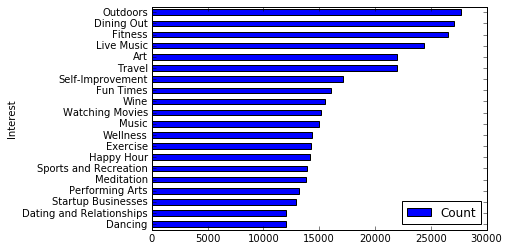

In [4]:
interests = []
c = Counter()
for row in cl_df['topics']:
    user_interests = []
    for interest in row:
        user_interests.append(interest['name'])
    interests.append(user_interests)
    c.update(user_interests)
cl_df['interests'] = interests
counter = pd.DataFrame()
counter['Interest'], counter['Count'] = zip(*c.most_common(20))
counter.sort_index(axis=0 ,ascending=False).plot(x='Interest', kind='barh')

In [5]:
print "There are %s unique interests" % len(c)

There are 21892 unique interests


In [61]:
print c.items()

[(u'Introvert does not mean anti-social', 3), (u'Spontaneous Creations', 1), (u'Poetry', 2502), (u'Allan Kardec', 3), (u'non profit and for profit networking', 5), (u'Unusual Vacations', 2), (u'Cross Dressing', 10), (u'French Parties', 3), (u'Business Model Generation', 1), (u'west africa', 1), (u'Open Source Python', 17), (u'Middle Eastern Food', 2), (u'Wedding Dance Routines', 2), (u'Secularism', 39), (u'Trail Horse Riding for Women', 1), (u'Glass Sculpture', 3), (u'Health Information Technology', 17), (u'Digital Workflow', 1), (u'Nintendo 64', 2), (u'Single Young Ladies', 4), (u'Travelers American Academy of Professional Coders.', 1), (u'Nintendo 3DS', 8), (u'Retirement for Federal Employees', 1), (u'Hiking & Backpacking', 4), (u'HR Business Partners', 1), (u'Black Men Sales Professionals', 1), (u'Creative blogging', 1), (u'Coming out', 1), (u'Music Industry', 238), (u'Fun for Friends and Their Friends', 2), (u'Management Consulting', 4), (u'Party Plan', 3), (u'Non-Denominational Ch

It would be useful to obtain an histogram related to the number of interests each person has indicated. We create an additional column with this number.

C:\Users\Rapssail\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


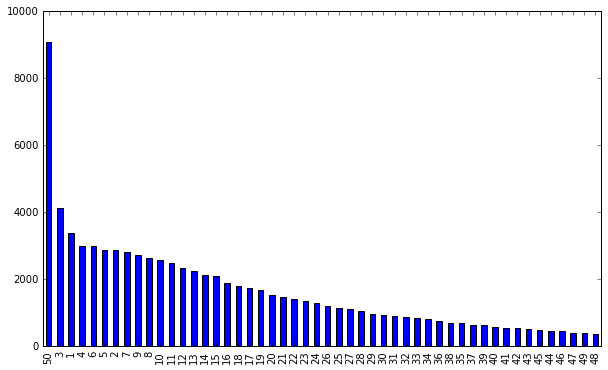

In [6]:
interests_count = []
for row in cl_df['interests']:
    num_of_interests = len(row)
    interests_count.append(num_of_interests)
cl_df['interests_count'] = interests_count
cl_df['interests_count'].value_counts().plot(kind='bar', figsize=(10,6))

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

def my_tokenizer(mylist):
    return mylist

vectorizer = TfidfVectorizer(tokenizer = my_tokenizer, lowercase = False)
X = vectorizer.fit_transform(x for x in cl_df["interests"])
print X.shape

(82186, 21892)


In [33]:
from sklearn.metrics.pairwise import cosine_similarity
sims = cosine_similarity(X[0:10000,:])

In [36]:
print np.argsort(sims[1,:])

[4999 6493 6494 ...,  112   11    1]


In [40]:
print sims[1,11]

0.809839810482


In [41]:
print cl_df["interests"][1]

[u'Black Professionals', u'Black Entrepreneurs', u'African Americans in South Florida', u'Miami African Americans', u'Black women in Miami', u'Singles', u'Dining Out', u'Nightlife', u'Social Networking', u'VIP Parties', u'Pug', u'Watching Movies', u'New In Town', u"Women's Social", u'Fun Times', u"Girls' Night Out", u"Women's Empowerment", u'Professional Women', u'Pug Rescue', u'Pug Information', u'Pug Play Group', u'Pug Meet', u'Weight Loss', u'Fitness', u'Self-Improvement', u'Wellness', u'Group Fitness Training', u'Outdoor  Fitness', u'Personal Training', u'Fitness Boot Camp', u'Exercise', u'Outdoor Fitness Boot Camp', u'Group Cardio Classes', u'Muscle Toning', u'Spades', u'Card Games', u'Board Games', u'Success', u'Professional Networking', u"Singles 30's-50's", u'Single Professionals', u'Dating and Relationships', u'Young Professional Singles', u'Social', u'Adventure', u'Self-Empowerment', u'Wine', u'Travel', u'Live Music', u'Dancing']


In [55]:
print cl_df[112]

KeyError: 112

In [43]:
set(cl_df["interests"][1]) & set(cl_df["interests"][11])

{u'Adventure',
 u'Dining Out',
 u'Fitness',
 u'Live Music',
 u'Outdoor  Fitness',
 u'Pug',
 u'Travel',
 u'Wine'}